In [115]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

In [94]:
contaminated_df = pd.read_csv("../../data/contaminated/data_contaminated3.csv")
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')


In [95]:
#contaminated_df.head

In [96]:
contaminated_sentences = contaminated_df['combined_text'].tolist()
embeddings = model.encode(contaminated_sentences)

print(embeddings[:5])


[[ 0.28227794  0.12621348 -0.05208312 ... -0.07339635  0.24025863
   0.1327806 ]
 [ 0.43039504  0.03634816 -0.04758246 ... -0.22186738 -0.22349276
   0.06129763]
 [ 0.27479756  0.28263614  0.24597012 ... -0.0940499   0.38327062
   0.55718064]
 [ 0.3451237   0.03631111  0.24890196 ... -0.16847862 -0.6559895
   0.48840496]
 [ 0.35484728  0.07293423  0.34847844 ...  0.02546211  0.13973124
   0.35689235]]


In [97]:
# Normalisation des données
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(embeddings)

In [98]:
# Diviser en ensembles d'entraînement et de test
X_train, X_test = train_test_split(scaled_embeddings, test_size=0.2, random_state=42)

In [99]:
#partie compression de l'entree
input_dim = embeddings.shape[1]
encoding_dim = 32
print(input_dim)

384


In [100]:
input_layer = keras.Input(shape=(input_dim,))
# Encodeur
encoder = layers.Dense(64, activation='relu')(input_layer)
encoder = layers.Dense(encoding_dim, activation='relu')(encoder)

# Décodeur
decoder = layers.Dense(64, activation='relu')(encoder)
decoder = layers.Dense(input_dim, activation='sigmoid')(decoder)

In [101]:
# Modèle complet
autoencoder = keras.Model(input_layer, decoder)

# Modèle encodeur (pour extraire les features compressées)
encoder_model = keras.Model(input_layer, encoder)

# Compiler le modèle
autoencoder.compile(optimizer='adam', loss='mse')

In [102]:
# Entraîner l'auto-encodeur
autoencoder.fit(
    X_train, X_train,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(X_test, X_test)
)

Epoch 1/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.1390 - val_loss: 0.9110
Epoch 2/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9066 - val_loss: 0.8412
Epoch 3/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8327 - val_loss: 0.8018
Epoch 4/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7983 - val_loss: 0.7787
Epoch 5/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7849 - val_loss: 0.7635
Epoch 6/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7613 - val_loss: 0.7544
Epoch 7/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7751 - val_loss: 0.7467
Epoch 8/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7549 - val_loss: 0.7398
Epoch 9/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7402 - val_loss: 0.7345
Epoch 10/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7443 - val_loss: 0.7303
Epoch 11/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7414 - val_loss: 0.7271
Epoch 12/50
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7385 - val_lo

In [103]:
# Reconstruire les inputs
reconstructed = autoencoder.predict(scaled_embeddings)

# Calculer l'erreur de reconstruction
mse = np.mean(np.power(scaled_embeddings - reconstructed, 2), axis=1)

# Ajouter les scores d'anomalie au DataFrame
contaminated_df['reconstruction_error'] = mse

# Extraire les embeddings réduits
reduced_embeddings = encoder_model.predict(scaled_embeddings)


107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step


In [104]:
reduced_embeddings_df = pd.DataFrame(
    reduced_embeddings, 
    columns=[f'reduced_dim_{i}' for i in range(encoding_dim)]
)

In [110]:
# Sauvegarder les résultats
final_df = pd.concat([contaminated_df, reduced_embeddings_df], axis=1)
final_df.to_csv("../../data/contaminated/autoencoder_results.csv", index=False)

threshold = np.percentile(mse, 95)  # Les 5% supérieurs sont considérés comme anomalies
contaminated_df['is_anomaly_autoencoder'] = mse > threshold
anomalies_percentile = mse > threshold
print(threshold)
print(f"Nombre d'anomalies détectées (percentile): {sum(anomalies_percentile)}")

1.4640698790550215
Nombre d'anomalies détectées (percentile): 171


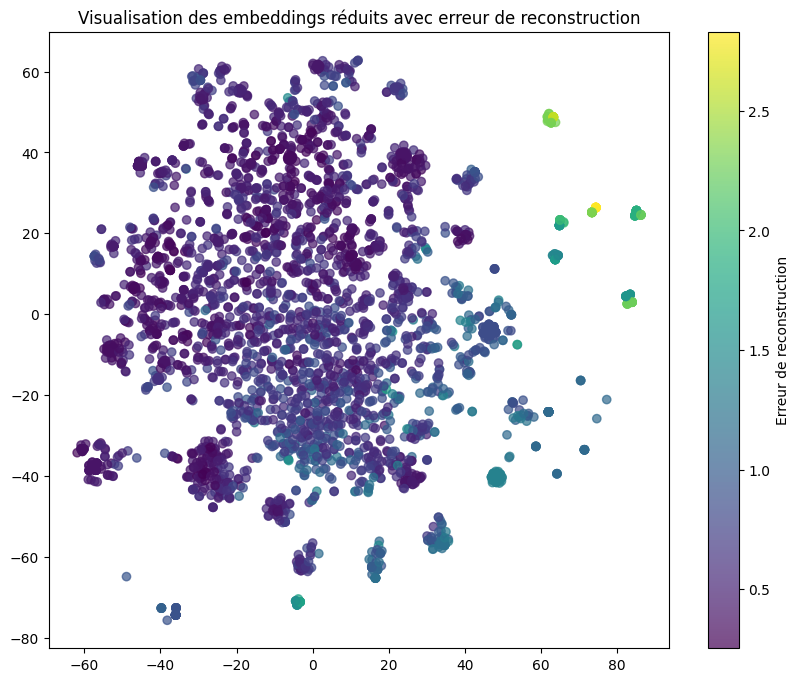

In [111]:
#cette partie permet juste de voir à quoi ressemble les ambedings après reduction de dimension et voir egalement
#les erreurs de reconstruction pour identifier les anomalies
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Réduire à 2D pour la visualisation si encoding_dim > 2
if encoding_dim > 2:
    tsne = TSNE(n_components=2, random_state=42)
    reduced_2d = tsne.fit_transform(reduced_embeddings)
else:
    reduced_2d = reduced_embeddings

plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_2d[:, 0], reduced_2d[:, 1], 
                     c=mse, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Erreur de reconstruction')
plt.title('Visualisation des embeddings réduits avec erreur de reconstruction')
plt.savefig('embeddings_visualization.png')
plt.show()

In [112]:
contaminated_df.head()

,combined_text,reconstruction_error,is_anomaly,is_anomaly_autoencoder
0,cardiac silhouette mediastinum size within nor...,0.399290,False,False
1,cardiomediastinal silhouette within normal lim...,0.365226,False,False
2,lung clear epanded heart mediastinum normal ac...,1.387749,False,False
3,increased_opacity within right_upper_lobe poss...,0.822116,False,False
4,interstitial marking diffusely prominent throu...,1.122873,False,False


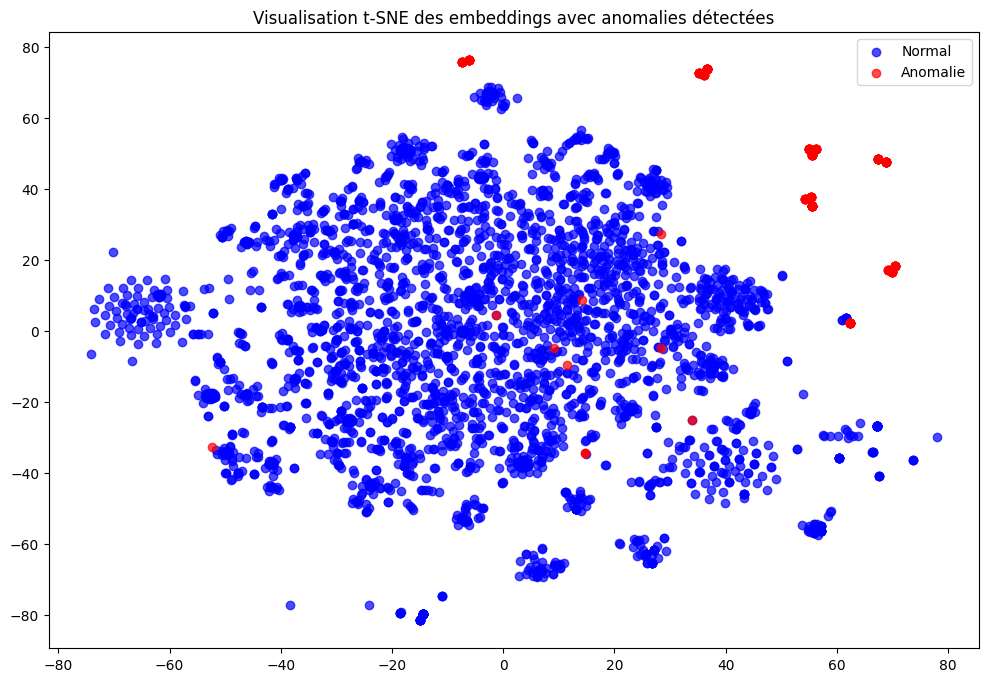

In [113]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
embedding_2d = tsne.fit_transform(scaled_embeddings)

plt.figure(figsize=(12, 8))
plt.scatter(embedding_2d[contaminated_df['is_anomaly_autoencoder'] == False, 0], 
            embedding_2d[contaminated_df['is_anomaly_autoencoder'] == False, 1], 
            c='blue', alpha=0.7, label='Normal')

plt.scatter(embedding_2d[contaminated_df['is_anomaly_autoencoder'] == True, 0], 
            embedding_2d[contaminated_df['is_anomaly_autoencoder'] == True, 1], 
            c='red', alpha=0.7, label='Anomalie')

plt.title('Visualisation t-SNE des embeddings avec anomalies détectées')
plt.legend()
plt.show()


In [118]:
# Création d'un DataFrame basé sur X_test
contaminated_df_test = pd.DataFrame(X_test, columns=[f'feature_{i}' for i in range(X_test.shape[1])])

# Isolation Forest (entraînement sur X_train)
isolation_forest = IsolationForest(contamination=0.05, random_state=42)
isolation_forest.fit(X_train)
contaminated_df_test['is_anomaly_iforest'] = isolation_forest.predict(X_test) == -1

In [119]:
# One-Class SVM (entraînement sur X_train)
oc_svm = OneClassSVM(nu=0.05, kernel='rbf')
oc_svm.fit(X_train)
contaminated_df_test['is_anomaly_ocsvm'] = oc_svm.predict(X_test) == -1